In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import os
from torchinfo import summary

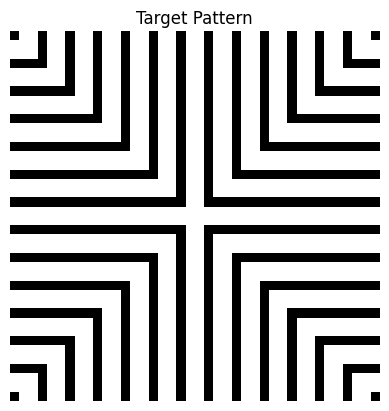

In [3]:
def load_pattern(image_number, target_size=(40, 40)):
    image_path = f'training_img/pattern{image_number}.png'
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        # transforms.Resize(target_size),
        transforms.ToTensor()
    ])
    image_tensor = transform(image)
    return image_tensor.unsqueeze(0)

target_pattern = load_pattern(1).to(torch.float32)
plt.imshow(target_pattern[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Target Pattern')
plt.axis('off')
plt.show()

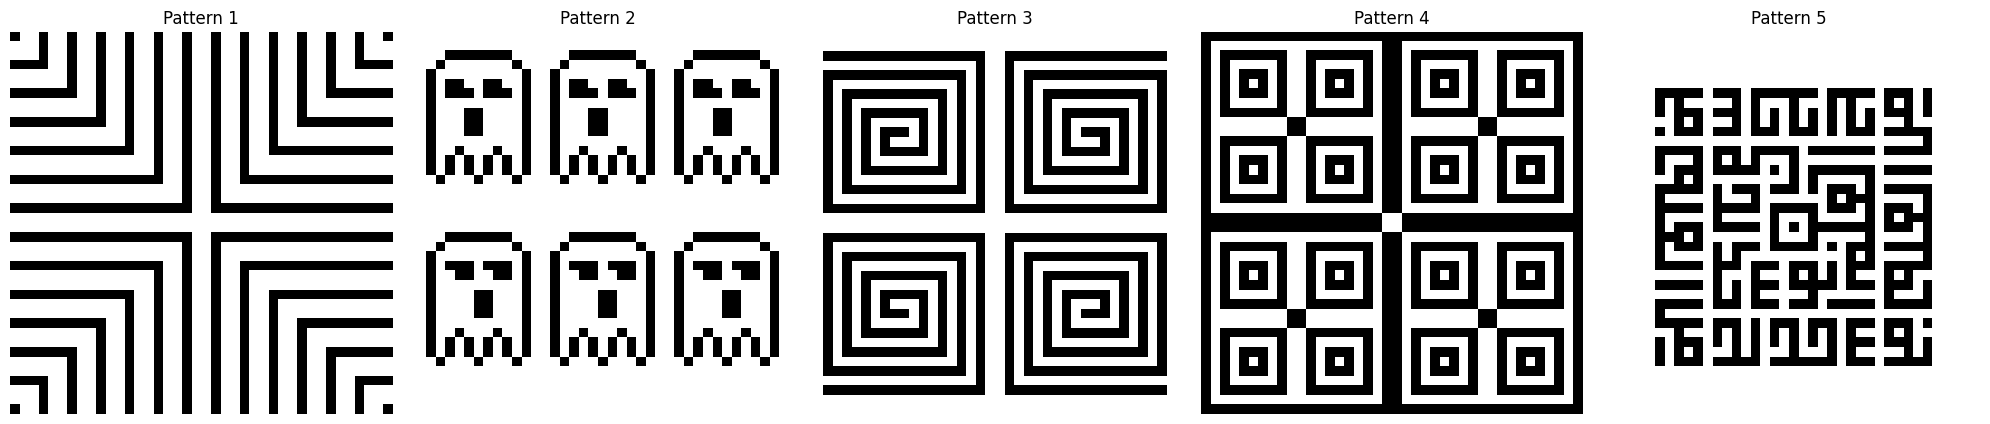

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
for idx, ax in enumerate(axes.flat):
    if idx < 6:
        pattern = load_pattern(idx + 1).to(torch.float32)
        ax.imshow(pattern[0, 0].detach().cpu().numpy(), cmap='gray')
        ax.set_title(f'Pattern {idx + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
class PatternDataset(torch.utils.data.Dataset):
    def __init__(self, maze_tensors):
        self.maze_tensors = maze_tensors
    
    def __len__(self):
        return len(self.maze_tensors)
    
    def __getitem__(self, idx):
        return self.maze_tensors[idx]
    
target_pattern = load_pattern(1).to(torch.float32)    
dataset = PatternDataset(target_pattern)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [6]:
class CA(nn.Module):
    def __init__(self, state_dim=16, hidden_dim=128):
        super(CA, self).__init__()
        self.state_dim = state_dim
        self.update = nn.Sequential(
            nn.Conv2d(state_dim, 3*state_dim, 3, padding=1, groups=state_dim, bias=False), 
            nn.Conv2d(3*state_dim, hidden_dim, 1),  
            nn.ReLU(),  # Nonlinearity
            nn.Conv2d(hidden_dim, state_dim, 1)  # Output
        )
        self.update[-1].weight.data *= 0  # Initial residual updates should be close to zero

        identity = np.outer([0, 1, 0], [0, 1, 0])  # identity filter
        dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel x filter
        kernel = np.stack([identity, dx, dx.T], axis=0)  # stack (identity, dx, dy) filters
        kernel = np.tile(kernel, [state_dim, 1, 1])  # tile over channel dimension
        self.update[0].weight.data[...] = torch.Tensor(kernel)[:, None, :, :]
        self.update[0].weight.requires_grad = False
    

    def forward(self, x, num_steps):
        alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1
        frames = []
        for i in range(num_steps):
            alive_mask_pre = alive_mask(alpha=x[:, 3:4])
            x = x + (self.update(x) * alive_mask_pre)  # state update!
            frames.append(x.clone())
        return torch.stack(frames)  
    
def normalize_grads(model):  # makes training more stable early on
    for p in model.parameters():
        p.grad = p.grad / (p.grad.norm() + 1e-8) if p.grad is not None else p.grad

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
state_dim = 16
grid_size = 40

model = CA(state_dim=state_dim, hidden_dim=128).to(device)
summary(model.update)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            (432)
├─Conv2d: 1-2                            6,272
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            2,064
Total params: 8,768
Trainable params: 8,336
Non-trainable params: 432

Epoch [0/2001], Loss: 2.0599
Epoch [500/2001], Loss: 0.0250
Epoch [1000/2001], Loss: 0.0010
Epoch [1500/2001], Loss: 0.0024
Epoch [2000/2001], Loss: 0.0012


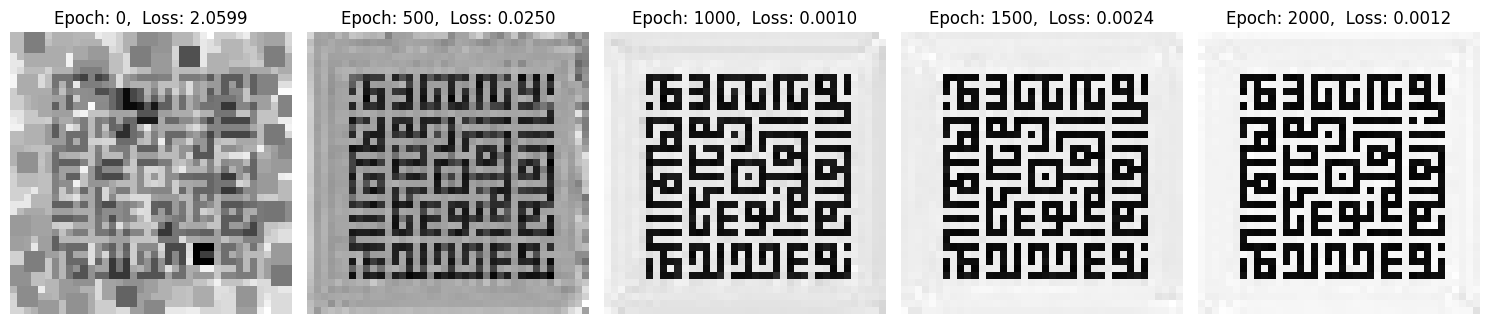

In [12]:
# Choose a number of the pattern
target_pattern = load_pattern(5).to(torch.float32)    
dataset = PatternDataset(target_pattern)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
num_epochs = 2001
grid_size = 40

images = []
losses = []
epochs_to_save = list(range(0, num_epochs+1, 500))

model = CA(state_dim=state_dim, hidden_dim=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    for batch in dataloader:
        target = batch.to(device)  # Move target maze to the appropriate device
        grid = torch.randn(1, state_dim, grid_size, grid_size).to(device)
        if epoch % 2 == 0:
            grid[0, 0, :, :] = target.clone()
        
        optimizer.zero_grad()
        output = model(grid, num_steps=150)
        
        loss = criterion(output[-1, :, :1, :, :], target)  # Compare only the first channel with the target
        
        loss.backward()
        normalize_grads(model)
        optimizer.step()

    if epoch in epochs_to_save:
        los = loss.item()
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {los:.4f}')
        losses.append(los)

        
        # Visualization: Collect the first channel of the first sample in the batch
        output_np = output[-1, 0, 0].detach().cpu().numpy()
        images.append(output_np)

# Plot all collected images in a grid
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        ax.imshow(images[idx], cmap='gray')
        ax.set_title(f'Epoch: {epochs_to_save[idx]},  Loss: {losses[idx]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

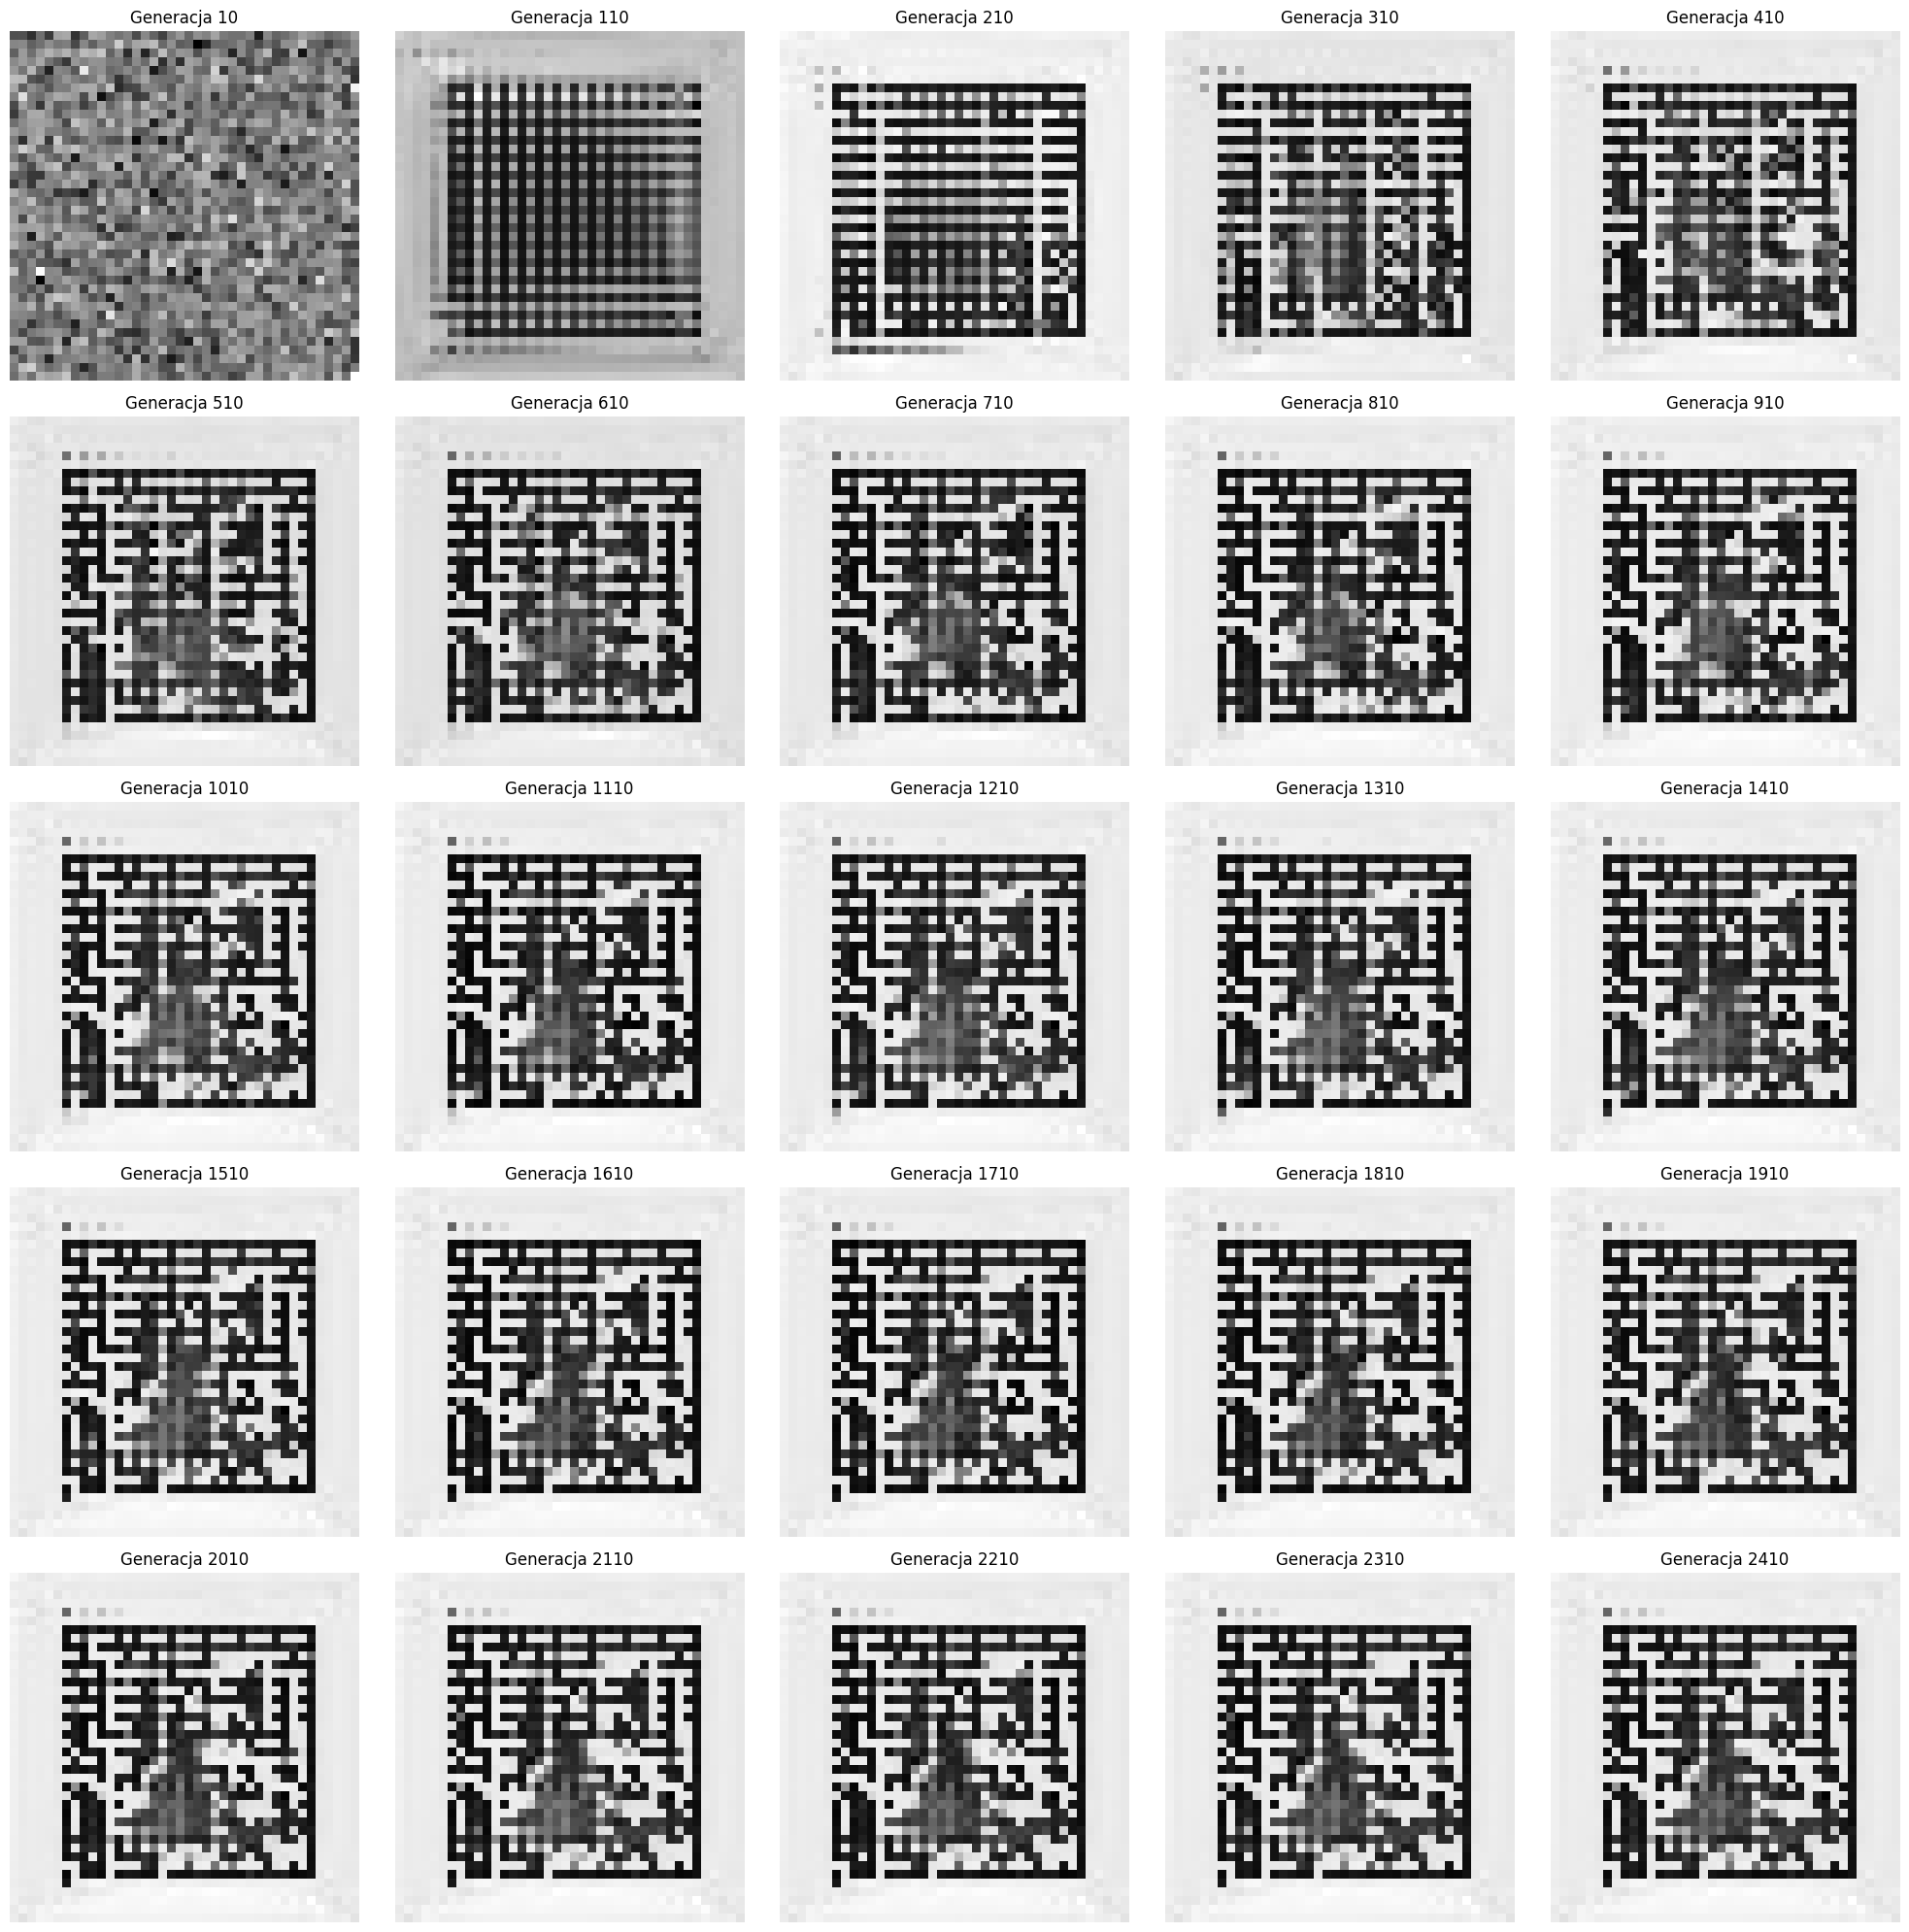

In [14]:
model.eval()
grid_size = 40

# Generate initial random grid and move to appropriate device
grid = torch.randn(1, state_dim, grid_size, grid_size).to(device)

# Create a figure with a 3x5 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# Iterate through each subplot and generate model output for increasing steps
for idx, ax in enumerate(axes.flat):
    num_steps = idx * 100 + 10
    with torch.no_grad():  # Ensure no gradients are calculated during inference
        output = model(grid, num_steps=num_steps)
    ax.imshow(output[-1, 0, 0].cpu().numpy(), cmap='gray')
    ax.set_title(f'Generacja {num_steps}')
    ax.axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()